In [22]:
import os
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import preprocessing

In [2]:
data_dir = os.path.join(os.path.dirname(os.getcwd()), "data")
pat_num = 9

In [3]:
mar9 = preprocessing.load_mar_data(data_dir, pat_num)
sickbay9 = preprocessing.load_sickbay_data(data_dir, pat_num)
accel9 = preprocessing.load_accel_data(data_dir, pat_num)
ecg9 = preprocessing.load_ecg_data(data_dir, pat_num)

In [12]:
print(mar9.head())
print(mar9.tail())

                 time  dose       mar_action  \
0 2024-01-11 01:48:00  60.0      ['New Bag']   
1 2024-01-11 02:00:00  60.0  ['Rate Verify']   
2 2024-01-11 03:00:00  60.0  ['Rate Verify']   
3 2024-01-11 03:19:00  80.0      ['New Bag']   
4 2024-01-11 04:00:00  60.0  ['Rate Verify']   

                                            med_name  
0  ['DEXTROSE 5 % AND 0.9 % SODIUM CHLORIDE INTRA...  
1  ['DEXTROSE 5 % AND 0.9 % SODIUM CHLORIDE INTRA...  
2  ['DEXTROSE 5 % AND 0.9 % SODIUM CHLORIDE INTRA...  
3  ['SULFAMETHOXAZOLE-TRIMETHOPRIM IV 0.8 MG/ML (...  
4  ['DEXTROSE 5 % AND 0.9 % SODIUM CHLORIDE INTRA...  
                    time   dose mar_action  \
2545 2024-02-07 08:19:00    1.0  ['Given']   
2546 2024-02-07 08:19:00  400.0  ['Given']   
2547 2024-02-07 08:20:00   10.0  ['Given']   
2548 2024-02-07 08:20:00  176.0  ['Given']   
2549 2024-02-07 09:40:00   17.0  ['Given']   

                                               med_name  
2545      ['DEXAMETHASONE 1 MG/ML DROPS (CONCE

In [13]:
print(sickbay9.head())
print(sickbay9.tail())

                 time  heart_rate  SpO2  respiratory_rate  \
0 2024-01-15 13:00:00        92.0  98.0              22.0   
1 2024-01-15 13:00:02        91.0  98.0              22.0   
2 2024-01-15 13:00:04        91.0  98.0              22.0   
3 2024-01-15 13:00:06        90.0  98.0              22.0   
4 2024-01-15 13:00:08        90.0  98.0              22.0   

   blood_pressure_systolic  blood_pressure_mean  blood_pressure_diastolic  
0                    114.0                 79.0                      56.0  
1                    114.0                 79.0                      56.0  
2                    114.0                 79.0                      56.0  
3                    114.0                 79.0                      56.0  
4                    114.0                 79.0                      56.0  
                      time  heart_rate  SpO2  respiratory_rate  \
389774 2024-01-24 15:36:34        86.0  96.0              17.0   
389775 2024-01-24 15:36:36        86.0  96.0 

In [15]:
print(accel9.head())
print(accel9.tail())

                 time         X         Y         Z  IdleSleepMode
0 2024-01-15 12:20:00 -0.097656  0.007812 -1.031250          False
1 2024-01-15 12:20:00 -0.085938 -0.035156 -1.003906          False
2 2024-01-15 12:20:00 -0.089844 -0.039062 -1.007812          False
3 2024-01-15 12:20:00 -0.085938 -0.039062 -1.007812          False
4 2024-01-15 12:20:00 -0.082031 -0.035156 -1.007812          False
                        time         X         Y         Z  IdleSleepMode
19118095 2024-01-17 17:26:51  0.371094  0.183594 -0.863281          False
19118096 2024-01-17 17:26:51  0.410156  0.195312 -0.847656          False
19118097 2024-01-17 17:26:51  0.449219  0.210938 -0.832031          False
19118098 2024-01-17 17:26:51  0.304688  0.015625 -0.648438          False
19118099 2024-01-17 17:26:51  0.371094 -0.089844 -0.957031          False


In [14]:
print(ecg9.head())
print(ecg9.tail())

   sbs_score          start_time            end_time  \
0          1 2024-01-15 13:22:00 2024-01-15 13:37:00   
1          0 2024-01-15 13:50:00 2024-01-15 14:05:00   
2          1 2024-01-15 14:40:00 2024-01-15 14:55:00   
3          1 2024-01-15 15:32:00 2024-01-15 15:47:00   
4          0 2024-01-15 15:50:00 2024-01-15 16:05:00   

                                                ecg1  \
0  [[0.0102, 0.0306, 0.0408, 0.0408, 0.0306, 0.02...   
1  [[0.01785, 0.0204, 0.02295, 0.0255, 0.02805, 0...   
2  [[0.0, 0.0, -0.00255, -0.0051, -0.0051, -0.005...   
3  [[-0.02805, -0.02805, -0.02805, -0.02805, -0.0...   
4  [[0.01785, 0.0357, 0.0306, 0.01785, 0.00765, 0...   

                                                ecg2  \
0  [[0.0102, 0.03315, 0.0663, 0.0918, 0.0969, 0.0...   
1  [[0.04845, 0.04845, 0.051, 0.05355, 0.05865, 0...   
2  [[-0.00765, -0.00765, -0.0051, -0.0051, -0.005...   
3  [[-0.02805, -0.02805, -0.0306, -0.0306, -0.030...   
4  [[0.02295, 0.03315, 0.0306, 0.0204, 0.00765

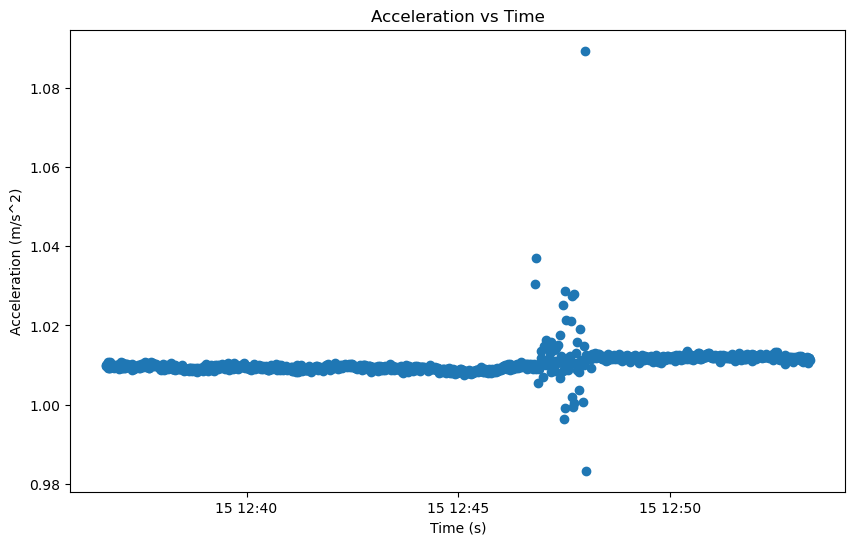

In [ ]:
accel9['a'] = np.sqrt(accel9['X']**2 + accel9['Y']**2 + accel9['Z']**2)
accel9_downsampled = pd.DataFrame(np.zeros((int(len(accel9)/100), 2)), columns=['time', 'a'])

for i in range(len(accel9_downsampled)):
    accel9_downsampled.loc[i, 'time'] = accel9['time'].iloc[i*100]
    accel9_downsampled.loc[i, 'a'] = np.average(accel9['a'].iloc[i*100:(i+1)*100])

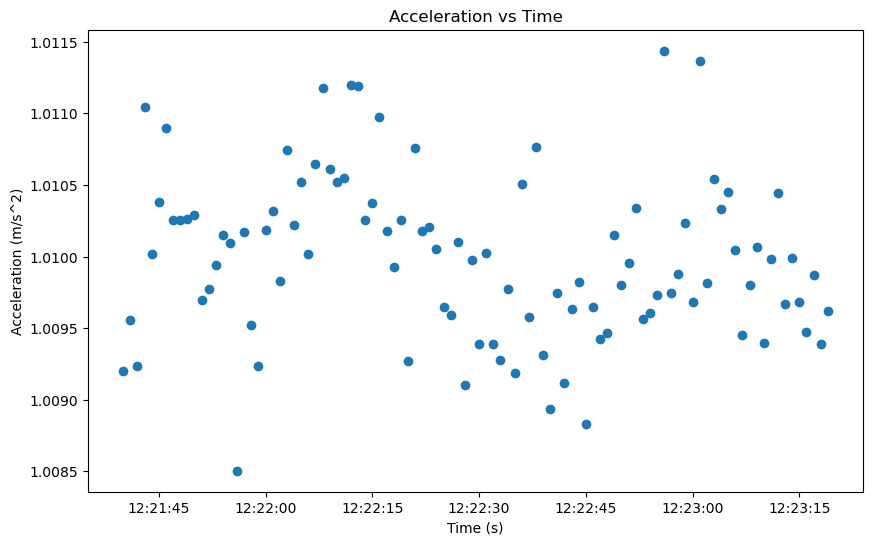

In [ ]:
accel9 = accel9_downsampled
accel9_sample = accel9[100:200]

plt.figure(figsize=(10, 6))
plt.plot(accel9_sample['time'], accel9_sample['a'])
plt.title('Acceleration vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.show()